<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/ce_ensemble_cifar_random_initial_weights_decorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_validation_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ce_ensemble_cifar_random_initial_weights_decorrelation

> Currently main idea is the following: pretrain ensemble in supervised fashion, with a score "decorrelation" term.

In [1]:
#| default_exp ce_ensemble_cifar_random_initial_weights_decorrelation

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [1]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [2]:
import os
os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')

0

In [3]:
#| hide
from nbdev.showdoc import *

In [4]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from cancer_proj.cancer_maintrain_ensemble import *
from cancer_proj.cancer_maintrain_ce import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


## Load the data

In [5]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
n_in=3
size=32
bs=256 #for training BT
bs_val=256 #for training linear head
bs_test=100 #for evaluating linear head. Divides 10000
ts_val=256 
ts=5120


# Load prior fnames:

In [6]:
#load
directory = '/content/drive/My Drive/cifar'
main_dict = load_dict_from_gdrive(directory=directory,filename='main_dict')

In [8]:
main_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 'fnames', 'fnames_train', 'fnames_val'])

In [7]:
fnames = main_dict['fnames']
fnames_train = main_dict['fnames_train']
fnames_val = main_dict['fnames_val']

In [8]:
#data: dls, dls_val, dls_test
#get the data: Need dls, dls_val, dls_test
path = untar_data(URLs.CIFAR)
#fnames = get_image_files(path / "train")
#fnames=fnames.shuffle()
# fnames_train = fnames[0:ts]
# fnames_val = fnames[ts:]

fnames_test = get_image_files(path / "test")
#fnames_test = fnames[ts+ts_val:ts+ts_val+ts_test]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]
labels_train = labels[0:ts]
labels_val = labels[ts:ts+ts_val]
labels_test = [label_func(fname) for fname in fnames_test]

#Used for training encoder i.e. BT
dls_train = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)
dls_tune = dls_train

test_eq(ts_val%bs_val,0)
dls_valid = ImageDataLoaders.from_lists(path, fnames_val, labels_val,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,shuffle=False)

#Used for evaluating linear classifier
dls_test = ImageDataLoaders.from_lists(path, fnames_test, labels_test,bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)

# labels = list(set(labels))
# dls_train.vocab = labels
# dls_tune.vocab = labels
# dls_valid.vocab = labels
# dls_test.vocab = labels




set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

## Load aug pipelines here

In [9]:
#| export

BYOL_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1
                )


TUNE_Augs=dict(blur_r = BYOL_Augs['blur_r'],blur_s = BYOL_Augs['blur_s'], flip_p=0.25,
                rotate_p=0.25,jitter_p=0.0,bw_p=0.0,blur_p=0.0,resize_scale=(0.7, 1.0),
                resize_ratio=(3/4, 4/3),rotate_deg=45.0
                )

Val_Augs = dict(TUNE_Augs)


def create_aug_pipelines(size,device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs):
    "Create the BT pipelines, the tune and val pipelines"

    aug_dict = {}

    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]


    aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=TUNE_Augs['resize_scale'],resize_ratio=TUNE_Augs['resize_ratio'],noise_std=None,
                    blur_r=TUNE_Augs['blur_r'],blur_s=TUNE_Augs['blur_s'], rotate_deg=TUNE_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=TUNE_Augs['flip_p'], rotate_p=TUNE_Augs['rotate_p'],noise_p=0.0, jitter_p=TUNE_Augs['jitter_p'],
                    bw_p=TUNE_Augs['bw_p'], blur_p=TUNE_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)




    aug_pipelines_test =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=Val_Augs['resize_scale'],resize_ratio=Val_Augs['resize_ratio'],noise_std=None,
                    blur_r=Val_Augs['blur_r'],blur_s=Val_Augs['blur_s'], rotate_deg=Val_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=Val_Augs['flip_p'], rotate_p=Val_Augs['rotate_p'],noise_p=0.0, jitter_p=Val_Augs['jitter_p'],
                    bw_p=Val_Augs['bw_p'], blur_p=Val_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)

    aug_dict['aug_pipelines'] = aug_pipelines
    aug_dict['aug_pipelines_tune'] = aug_pipelines_tune
    aug_dict['aug_pipelines_test'] = aug_pipelines_test

    return aug_dict



In [10]:
#| hide

_Augs = dict(BYOL_Augs)
_Augs['stats'] = cifar_stats
aug_dict = create_aug_pipelines(size=size,device=device,Augs=_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([

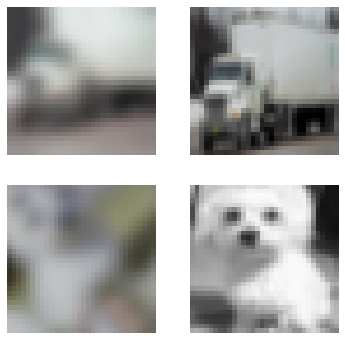

In [13]:
#| hide
show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


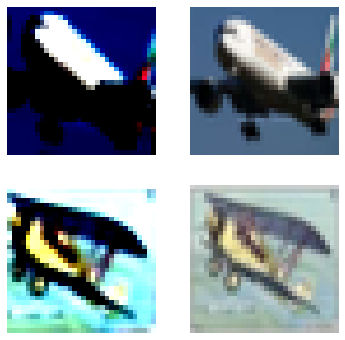

In [14]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [15]:
#| hide
#show_btens_batch(dls_train,3,aug_pipelines,n=2)

## Step 1) Train two BT models on CIFAR10, and save them

In [11]:
import os
directory = '/content/drive/My Drive/cifar'
if not os.path.exists(directory):
    os.makedirs(directory)

In [12]:
xval,yval = main_dict[0]['xval'], main_dict[0]['yval']

# Train a simple model with CE idea

In [13]:
class CeJointEnsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,encoder2,head):
        self.encoder = encoder
        self.encoder2 = encoder2
        self.head=head

    def forward(self,x):
        tem=self.encoder(x)
        tem2=self.encoder2(x)
        return tem,tem2,self.head(tem),self.head(tem2)


class CeIndivModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,head):
        self.encoder = encoder
        self.head=head

    def forward(self,x):
        tem=self.encoder(x)
        return tem,self.head(tem)

In [15]:
#| export

class CeJointEns(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines,n_in, lmb=5e-3,numout=10, print_augs=False):
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        self.n_in=n_in
        self.cross_entropy = CrossEntropyLossFlat()
        self.numout=numout
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        #nf = self.learn.model.encoder[-1].out_features
        self.nf = 8192
        self.I = torch.eye(self.nf).to(self.dls.device)


    def before_epoch(self):
        pass
  
    def before_batch(self):
        
        #TODO: Make this nicer (possibly can load in data as TensorImage(BW) or something?)
        #This is a bit of a hack. Can make this more elegant later. But in new version of FastAI
        #seems we need to compute TensorImage(BW) here, and depends on whether color or not, i.e. n_in.
        if self.n_in == 1:

            xi,xj = self.aug1(TensorImageBW(self.x)), self.aug2(TensorImageBW(self.x))
            
            #print(xi.shape)
                                    
        elif self.n_in == 3:
            
            xi,xj = self.aug1(TensorImage(self.x)), self.aug2(TensorImage(self.x))

        self.learn.xb = (torch.cat([xi, xj]),)
        
    def lf(self,pred,*yb): pass
        

    @torch.no_grad()
    def show(self, n=1): 
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:]
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]]
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)


class CeIndiv(CeJointEns):pass

In [39]:
#| export

def lf_ce2(pred,*yb,t,criterion=CrossEntropyLossFlat()):
    "Loss function for training ensemble jointly "
    

    pred,pred2,out,out2 = pred[0],pred[1],pred[2],pred[3] #encoder and head(encoder(.))
    y = yb[0]


    bs,nf = pred.size(0)//2,pred.size(1)

    out_1,out_2 = out[:bs],out[bs:]

    out2_1,out2_2 = out2[:bs],out2[bs:]

    CE1 = criterion(out_1,y)
    CE2 = criterion(out_2,y)
    CE = 0.5*(CE1 + CE2)

    CE2_1 = criterion(out2_1,y)
    CE2_2 = criterion(out2_2,y)
    CE2 = 0.5*(CE2_1 + CE2_2)

    CE = 0.5*CE + 0.5*CE2

    errs = 0.5*(out_1*out2_1).mean() + 0.5*(out_2*out2_2).mean() #like redundancy reduction    

    #loss = t*rr + CE
    loss = CE + t*errs

    return loss



In [17]:
#| export

def lf_ce(pred,*yb,criterion=CrossEntropyLossFlat()):
    "Loss function for training ensemble jointly "
    
    pred,out = pred[0],pred[1] #encoder and head(encoder(.))
    y = yb[0]

    bs,nf = pred.size(0)//2,pred.size(1)

    out_1,out_2 = out[:bs],out[bs:]

    CE1 = criterion(out_1,y)
    CE2 = criterion(out_2,y)
    loss = 0.5*(CE1 + CE2)

    return loss



In [18]:
class CeJointEnsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,encoder2):#,head):
        # print('inside __init__ of CeJointEnsModel:')
        # input(head)
        self.encoder = encoder
        self.encoder2 = encoder2
        #self.head=head

    def forward(self,x):
        tem=self.encoder(x)
        tem2=self.encoder2(x)
        return tem,tem2,self.head(tem),self.head(tem2)

In [33]:
@patch
def before_epoch(self:CeJointEns):

    #print(self.learn.head)
    self.learn.model.head = sequential(nn.Linear(2048,2048),nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                 nn.ReLU(),
                                 
                                 nn.Linear(2048,2048),nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                 nn.ReLU(),
                                 
                                  nn.Linear(2048,self.numout)).cuda()

    for p in self.learn.model.head.parameters():
        
        p.requires_grad=False

        
    self.t=0.1

In [20]:
@patch
def before_epoch(self:CeIndiv):
    

    #print(self.learn.head)
    self.learn.model.head = sequential(nn.Linear(2048,2048),nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                 nn.ReLU(),
                                 
                                 nn.Linear(2048,2048),nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                 nn.ReLU(),
                                 
                                  nn.Linear(2048,self.numout)).cuda()

    for p in self.learn.model.head.parameters():
        
        p.requires_grad=False

In [21]:
#| export

@patch
def lf(self:CeJointEns, pred,*yb): return lf_ce2(pred,*yb,t=self.t,criterion=CrossEntropyLossFlat())

In [22]:
@patch
def lf(self:CeIndiv, pred,*yb): return lf_ce(pred,*yb,criterion=CrossEntropyLossFlat())

Let's just keep it simple: pretrain for 50 epochs, train for 50 epochs, and save:

Our goal here is really just to verify that it is better than baseline, and to start writing the code for saving: if it works can go from there...

In [45]:
#pretrain

class main_ce_ens:
    "API to train either: `joint ensemble`; or individual net. Here train means pretrain + fine tune."


    def __init__(self,num_i): 
        store_attr()
        self.vocab = dls_train.vocab
        self.numout=len(self.vocab)


    def pretrain_joint(self):
        "pretrain two encoders using joint training policy"

        with torch.no_grad():
            _,encoder = create_model('no_pretrain',device)
            _,encoder2 = create_model('no_pretrain',device)

            ce_joint_model = CeJointEnsModel(encoder=encoder,encoder2=encoder2)#,head=None)

        learn = Learner(dls_train,ce_joint_model,cbs=[CeJointEns(aug_pipelines,n_in=3,numout=self.numout,lmb=None,print_augs=False)])

        learn.fit(50)

        self.encoder_dict = {'encoder_1':encoder,'encoder_2':encoder2}

    
    def pretrain_indiv(self):
        "pretrain one encder"

        with torch.no_grad():
            _,encoder = create_model('no_pretrain',device)
            ce_indiv_model = CeIndivModel(encoder=encoder,head=None)

        learn = Learner(dls_train,ce_indiv_model,cbs=[CeIndiv(aug_pipelines,n_in=3,numout=self.numout,lmb=None,print_augs=False)])
        learn.fit(50)
        self.invid_encoder=encoder

        return self.invid_encoder


    def fine_tune_indiv(self):
        "Fine tune individual model"
        

        model = LM(self.invid_encoder,numout=self.numout)
        learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
        learn.freeze()
        learn.fit(1)
        learn.unfreeze()
        learn.fit(50)

        scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
        metrics = classification_report_wrapper(preds, yval, self.vocab, print_report=True)

        auc_dict = plot_roc(yval,preds,self.vocab,print_plot=True)
        metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval

        path = directory + '/' + f'indiv_model_{i}' + f'num_{self.num_i}'
        torch.save(model.state_dict(),path)
        metrics['model_path'] = path

        return metrics
        

    
    def fine_tune_joint_ensemble(self):
        "fine tune two encoders that belong together: i.e. been jointly pretrained"

        #fine_tune
        METRICS={}
        for i,k in enumerate(self.encoder_dict):

        
            model = LM(self.encoder_dict[k],numout=self.numout) #so will be `encoder` or `encoder2`

            learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
            learn.freeze()
            learn.fit(1)
            learn.unfreeze()
            learn.fit(50)

            scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
            #metrics dict will have f1 score, auc etc etc
            metrics = classification_report_wrapper(preds, yval, self.vocab, print_report=True)
            auc_dict = plot_roc(yval,preds,self.vocab,print_plot=True)
            metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,xval,yval

            print(f'On run {self.num_i} acc for model {i} is {acc}')

            path = directory + '/' + f'joint_model_{i}' + f'num_{self.num_i}' #i.e. model 0 and model 1, on run num.
            torch.save(model.state_dict(),path)
            metrics['model_path'] = path

            METRICS[i]=metrics

        _,acc = predict_ensemble(scores1=METRICS[0]['scores'],scores2=METRICS[1]['scores'],yval=yval)

        print(f'On run {self.num_i} acc for first model is: {METRICS[0]["acc"]}')
        print(f'On run {self.num_i} acc for second model is: {METRICS[1]["acc"]}')
        print(f'On run {self.num_i} acc for ensemble is {acc}')

        METRICS['ensemble_acc'] = acc
        METRICS['docstring'] = 'encoders jointly trained'


        return METRICS
        #save_dict_to_gdrive(METRICS,directory,f'JointEnsembleMETRICS_{self.num_i}')





# Train

epoch,train_loss,valid_loss,time
0,2.275720,None,00:07
1,2.213660,None,00:07
2,2.167951,None,00:07
3,2.124405,None,00:07
4,2.087821,None,00:07
5,2.058660,None,00:07
6,2.035458,None,00:07
7,2.007540,None,00:07
8,1.986674,None,00:07
9,1.968673,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.433000,None,00:04


epoch,train_loss,valid_loss,time
0,1.340091,None,00:04
1,1.186231,None,00:04
2,1.063368,None,00:04
3,0.975796,None,00:04
4,0.918590,None,00:04
5,0.872828,None,00:04
6,0.837029,None,00:04
7,0.804614,None,00:04
8,0.764085,None,00:04
9,0.744222,None,00:04


              precision    recall  f1-score   support

    airplane       0.62      0.72      0.67        25
  automobile       0.56      0.75      0.64        20
        bird       0.60      0.56      0.58        27
         cat       0.61      0.56      0.58        25
        deer       0.41      0.47      0.44        15
         dog       0.70      0.68      0.69        28
        frog       0.79      0.73      0.76        30
       horse       0.76      0.73      0.75        30
        ship       0.87      0.76      0.81        34
       truck       0.71      0.68      0.70        22

    accuracy                           0.68       256
   macro avg       0.66      0.66      0.66       256
weighted avg       0.69      0.68      0.68       256

On run 0 acc for model 0 is 0.67578125


epoch,train_loss,valid_loss,time
0,1.468763,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.492209,None,00:04
1,1.246218,None,00:04
2,1.114742,None,00:04
3,1.021521,None,00:04
4,0.938110,None,00:04
5,0.875255,None,00:04
6,0.835522,None,00:04
7,0.811362,None,00:04
8,0.763804,None,00:04
9,0.746939,None,00:04


              precision    recall  f1-score   support

    airplane       0.82      0.72      0.77        25
  automobile       0.65      0.75      0.70        20
        bird       0.65      0.63      0.64        27
         cat       0.44      0.56      0.49        25
        deer       0.31      0.60      0.41        15
         dog       0.54      0.50      0.52        28
        frog       0.74      0.47      0.57        30
       horse       0.76      0.63      0.69        30
        ship       0.79      0.79      0.79        34
       truck       0.65      0.59      0.62        22

    accuracy                           0.62       256
   macro avg       0.64      0.62      0.62       256
weighted avg       0.66      0.62      0.63       256

On run 0 acc for model 1 is 0.625
On run 0 acc for first model is: 0.67578125
On run 0 acc for second model is: 0.625
On run 0 acc for ensemble is 0.7109375


epoch,train_loss,valid_loss,time
0,2.269934,None,00:06
1,2.198886,None,00:06
2,2.150119,None,00:06
3,2.098735,None,00:06
4,2.057327,None,00:06
5,2.018825,None,00:06
6,1.989595,None,00:06
7,1.967493,None,00:06
8,1.942674,None,00:06
9,1.924387,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.419109,None,00:04


epoch,train_loss,valid_loss,time
0,1.374058,None,00:04
1,1.175006,None,00:04
2,1.060944,None,00:04
3,0.969998,None,00:04
4,0.901193,None,00:04
5,0.840824,None,00:04
6,0.809698,None,00:04
7,0.786588,None,00:04
8,0.769371,None,00:04
9,0.740752,None,00:04


              precision    recall  f1-score   support

    airplane       0.73      0.88      0.80        25
  automobile       0.67      0.80      0.73        20
        bird       0.50      0.59      0.54        27
         cat       0.39      0.36      0.37        25
        deer       0.35      0.53      0.42        15
         dog       0.67      0.71      0.69        28
        frog       0.74      0.47      0.57        30
       horse       0.66      0.63      0.64        30
        ship       0.92      0.71      0.80        34
       truck       0.50      0.45      0.48        22

    accuracy                           0.62       256
   macro avg       0.61      0.61      0.60       256
weighted avg       0.64      0.62      0.62       256



epoch,train_loss,valid_loss,time
0,2.271296,None,00:07
1,2.223039,None,00:07
2,2.181658,None,00:07
3,2.142768,None,00:07
4,2.101444,None,00:07
5,2.075379,None,00:07
6,2.050465,None,00:07
7,2.027796,None,00:07
8,2.006208,None,00:07
9,1.981105,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.350287,None,00:04


epoch,train_loss,valid_loss,time
0,1.337949,None,00:04
1,1.143663,None,00:04
2,1.045737,None,00:04
3,0.962955,None,00:04
4,0.914526,None,00:04
5,0.851251,None,00:04
6,0.815509,None,00:04
7,0.815333,None,00:04
8,0.774126,None,00:04
9,0.749572,None,00:04


              precision    recall  f1-score   support

    airplane       0.87      0.80      0.83        25
  automobile       0.53      0.80      0.64        20
        bird       0.62      0.59      0.60        27
         cat       0.52      0.48      0.50        25
        deer       0.36      0.67      0.47        15
         dog       0.75      0.54      0.63        28
        frog       0.71      0.67      0.69        30
       horse       0.80      0.67      0.73        30
        ship       0.86      0.91      0.89        34
       truck       0.71      0.55      0.62        22

    accuracy                           0.67       256
   macro avg       0.67      0.67      0.66       256
weighted avg       0.70      0.67      0.68       256

On run 1 acc for model 0 is 0.671875


epoch,train_loss,valid_loss,time
0,1.322613,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.480500,None,00:04
1,1.222020,None,00:04
2,1.094230,None,00:04
3,1.012652,None,00:04
4,0.936825,None,00:04
5,0.893589,None,00:04
6,0.847061,None,00:04
7,0.807128,None,00:04
8,0.805393,None,00:04
9,0.753461,None,00:04


              precision    recall  f1-score   support

    airplane       0.70      0.92      0.79        25
  automobile       0.74      0.70      0.72        20
        bird       0.67      0.59      0.63        27
         cat       0.45      0.56      0.50        25
        deer       0.26      0.60      0.36        15
         dog       0.93      0.46      0.62        28
        frog       0.72      0.70      0.71        30
       horse       0.88      0.47      0.61        30
        ship       0.85      0.65      0.73        34
       truck       0.66      0.86      0.75        22

    accuracy                           0.64       256
   macro avg       0.68      0.65      0.64       256
weighted avg       0.71      0.64      0.65       256

On run 1 acc for model 1 is 0.64453125
On run 1 acc for first model is: 0.671875
On run 1 acc for second model is: 0.64453125
On run 1 acc for ensemble is 0.6953125


epoch,train_loss,valid_loss,time
0,2.288847,None,00:06
1,2.223979,None,00:06
2,2.175467,None,00:06
3,2.132007,None,00:06
4,2.095961,None,00:06
5,2.065195,None,00:05
6,2.039953,None,00:06
7,2.006213,None,00:06
8,1.973973,None,00:06
9,1.957142,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.561817,None,00:05


epoch,train_loss,valid_loss,time
0,1.405367,None,00:05
1,1.199529,None,00:05
2,1.074872,None,00:05
3,0.994235,None,00:05
4,0.950939,None,00:05
5,0.898886,None,00:05
6,0.848037,None,00:05
7,0.814306,None,00:05
8,0.785377,None,00:05
9,0.738068,None,00:05


              precision    recall  f1-score   support

    airplane       0.63      0.88      0.73        25
  automobile       0.80      0.40      0.53        20
        bird       0.61      0.70      0.66        27
         cat       0.54      0.56      0.55        25
        deer       0.45      0.60      0.51        15
         dog       0.70      0.50      0.58        28
        frog       0.81      0.70      0.75        30
       horse       0.70      0.63      0.67        30
        ship       0.79      0.79      0.79        34
       truck       0.59      0.73      0.65        22

    accuracy                           0.66       256
   macro avg       0.66      0.65      0.64       256
weighted avg       0.68      0.66      0.66       256



epoch,train_loss,valid_loss,time
0,2.270920,None,00:07
1,2.209800,None,00:07
2,2.157079,None,00:07
3,2.122739,None,00:07
4,2.097415,None,00:07
5,2.069863,None,00:07
6,2.043187,None,00:07
7,2.019820,None,00:07
8,1.994206,None,00:07
9,1.970109,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.660510,None,00:05


epoch,train_loss,valid_loss,time
0,1.402643,None,00:05
1,1.182491,None,00:05
2,1.080272,None,00:05
3,0.988653,None,00:05
4,0.914247,None,00:05
5,0.906637,None,00:05
6,0.868317,None,00:05
7,0.805861,None,00:05
8,0.767443,None,00:05
9,0.732763,None,00:05


              precision    recall  f1-score   support

    airplane       0.56      0.88      0.69        25
  automobile       0.50      0.75      0.60        20
        bird       0.64      0.52      0.57        27
         cat       0.39      0.56      0.46        25
        deer       0.44      0.53      0.48        15
         dog       0.71      0.71      0.71        28
        frog       0.68      0.57      0.62        30
       horse       0.68      0.63      0.66        30
        ship       0.94      0.44      0.60        34
       truck       0.71      0.45      0.56        22

    accuracy                           0.60       256
   macro avg       0.63      0.61      0.59       256
weighted avg       0.65      0.60      0.60       256

On run 2 acc for model 0 is 0.6015625


epoch,train_loss,valid_loss,time
0,1.470266,None,00:04


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.372969,None,00:04
1,1.192899,None,00:04
2,1.119320,None,00:04
3,1.021554,None,00:05
4,0.950730,None,00:04
5,0.886747,None,00:04
6,0.839608,None,00:05
7,0.796509,None,00:04
8,0.765750,None,00:04
9,0.768766,None,00:05


              precision    recall  f1-score   support

    airplane       0.80      0.64      0.71        25
  automobile       0.76      0.65      0.70        20
        bird       0.65      0.63      0.64        27
         cat       0.64      0.56      0.60        25
        deer       0.59      0.67      0.62        15
         dog       0.62      0.71      0.67        28
        frog       0.68      0.83      0.75        30
       horse       0.79      0.77      0.78        30
        ship       0.79      0.88      0.83        34
       truck       0.67      0.55      0.60        22

    accuracy                           0.70       256
   macro avg       0.70      0.69      0.69       256
weighted avg       0.71      0.70      0.70       256

On run 2 acc for model 1 is 0.703125
On run 2 acc for first model is: 0.6015625
On run 2 acc for second model is: 0.703125
On run 2 acc for ensemble is 0.703125


epoch,train_loss,valid_loss,time
0,2.274246,None,00:06
1,2.207142,None,00:06
2,2.150208,None,00:06
3,2.109524,None,00:06
4,2.065202,None,00:06
5,2.027601,None,00:06
6,1.996741,None,00:06
7,1.984428,None,00:06
8,1.954279,None,00:06
9,1.933708,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.324643,None,00:04


epoch,train_loss,valid_loss,time
0,1.310799,None,00:05
1,1.144156,None,00:05
2,1.027136,None,00:04
3,0.931967,None,00:05
4,0.883926,None,00:04
5,0.837079,None,00:04
6,0.788839,None,00:04
7,0.757460,None,00:04
8,0.743071,None,00:04
9,0.721753,None,00:05


              precision    recall  f1-score   support

    airplane       0.73      0.76      0.75        25
  automobile       0.76      0.65      0.70        20
        bird       0.75      0.44      0.56        27
         cat       0.47      0.60      0.53        25
        deer       0.26      0.33      0.29        15
         dog       0.53      0.57      0.55        28
        frog       0.72      0.70      0.71        30
       horse       0.79      0.73      0.76        30
        ship       0.79      0.97      0.87        34
       truck       0.82      0.64      0.72        22

    accuracy                           0.66       256
   macro avg       0.66      0.64      0.64       256
weighted avg       0.68      0.66      0.66       256



epoch,train_loss,valid_loss,time
0,2.283660,None,00:08
1,2.218647,None,00:08
2,2.168775,None,00:08
3,2.125482,None,00:08
4,2.085388,None,00:08
5,2.057092,None,00:08
6,2.035816,None,00:08
7,2.006524,None,00:08
8,1.985804,None,00:08
9,1.966655,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.376282,None,00:04


epoch,train_loss,valid_loss,time
0,1.450137,None,00:05
1,1.214768,None,00:05
2,1.080386,None,00:05
3,0.977902,None,00:05
4,0.926634,None,00:05
5,0.887360,None,00:05
6,0.842944,None,00:05
7,0.806104,None,00:05
8,0.780178,None,00:05
9,0.723127,None,00:05


              precision    recall  f1-score   support

    airplane       0.95      0.80      0.87        25
  automobile       0.62      0.50      0.56        20
        bird       0.54      0.56      0.55        27
         cat       0.53      0.40      0.45        25
        deer       0.46      0.40      0.43        15
         dog       0.42      0.96      0.59        28
        frog       0.88      0.50      0.64        30
       horse       0.89      0.57      0.69        30
        ship       0.81      0.74      0.77        34
       truck       0.50      0.64      0.56        22

    accuracy                           0.62       256
   macro avg       0.66      0.61      0.61       256
weighted avg       0.68      0.62      0.63       256

On run 3 acc for model 0 is 0.62109375


epoch,train_loss,valid_loss,time
0,1.333538,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.351918,None,00:05
1,1.133369,None,00:04
2,0.999379,None,00:05
3,0.924563,None,00:05
4,0.909639,None,00:05
5,0.862307,None,00:05
6,0.835037,None,00:05
7,0.802724,None,00:05
8,0.767314,None,00:05
9,0.728415,None,00:05


              precision    recall  f1-score   support

    airplane       0.79      0.76      0.78        25
  automobile       0.82      0.70      0.76        20
        bird       0.68      0.63      0.65        27
         cat       0.46      0.68      0.55        25
        deer       0.46      0.40      0.43        15
         dog       0.74      0.61      0.67        28
        frog       0.69      0.73      0.71        30
       horse       0.74      0.77      0.75        30
        ship       0.83      0.85      0.84        34
       truck       0.84      0.73      0.78        22

    accuracy                           0.70       256
   macro avg       0.71      0.69      0.69       256
weighted avg       0.72      0.70      0.71       256

On run 3 acc for model 1 is 0.703125
On run 3 acc for first model is: 0.62109375
On run 3 acc for second model is: 0.703125
On run 3 acc for ensemble is 0.703125


epoch,train_loss,valid_loss,time
0,2.263764,None,00:06
1,2.210386,None,00:06
2,2.145779,None,00:06
3,2.095887,None,00:06
4,2.057398,None,00:06
5,2.022265,None,00:06
6,1.995595,None,00:06
7,1.967237,None,00:06
8,1.943650,None,00:06
9,1.928493,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.584667,None,00:05


epoch,train_loss,valid_loss,time
0,1.461690,None,00:05
1,1.254964,None,00:05
2,1.172680,None,00:06
3,1.101479,None,00:05
4,1.021846,None,00:06
5,0.958634,None,00:05
6,0.898552,None,00:06
7,0.844727,None,00:05
8,0.804773,None,00:06
9,0.771173,None,00:05


              precision    recall  f1-score   support

    airplane       0.67      0.88      0.76        25
  automobile       0.67      0.60      0.63        20
        bird       0.78      0.52      0.62        27
         cat       0.56      0.60      0.58        25
        deer       0.52      0.73      0.61        15
         dog       0.81      0.46      0.59        28
        frog       0.63      0.73      0.68        30
       horse       0.61      0.77      0.68        30
        ship       0.88      0.82      0.85        34
       truck       0.56      0.45      0.50        22

    accuracy                           0.66       256
   macro avg       0.67      0.66      0.65       256
weighted avg       0.68      0.66      0.66       256



epoch,train_loss,valid_loss,time
0,2.275568,None,00:08
1,2.223368,None,00:08
2,2.175392,None,00:08
3,2.144850,None,00:08
4,2.105157,None,00:08
5,2.068078,None,00:08
6,2.042718,None,00:08
7,2.021817,None,00:08
8,1.990511,None,00:08
9,1.966731,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.345433,None,00:05


epoch,train_loss,valid_loss,time
0,1.478645,None,00:05
1,1.230180,None,00:05
2,1.116064,None,00:05
3,0.993781,None,00:05
4,0.925188,None,00:05
5,0.898242,None,00:05
6,0.853407,None,00:05
7,0.817715,None,00:05
8,0.777327,None,00:05
9,0.736871,None,00:05


              precision    recall  f1-score   support

    airplane       0.67      0.80      0.73        25
  automobile       0.77      0.50      0.61        20
        bird       0.65      0.63      0.64        27
         cat       0.57      0.52      0.54        25
        deer       0.44      0.53      0.48        15
         dog       0.56      0.71      0.63        28
        frog       1.00      0.57      0.72        30
       horse       0.72      0.77      0.74        30
        ship       0.78      0.85      0.82        34
       truck       0.58      0.64      0.61        22

    accuracy                           0.67       256
   macro avg       0.67      0.65      0.65       256
weighted avg       0.69      0.67      0.67       256

On run 4 acc for model 0 is 0.66796875


epoch,train_loss,valid_loss,time
0,1.281697,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.262306,None,00:05
1,1.133028,None,00:05
2,1.066963,None,00:05
3,0.992032,None,00:05
4,0.916114,None,00:05
5,0.881409,None,00:05
6,0.853093,None,00:06
7,0.812713,None,00:06
8,0.771619,None,00:06
9,0.720106,None,00:06


              precision    recall  f1-score   support

    airplane       0.81      0.84      0.82        25
  automobile       0.74      0.70      0.72        20
        bird       0.69      0.74      0.71        27
         cat       0.75      0.48      0.59        25
        deer       0.40      0.67      0.50        15
         dog       0.69      0.79      0.73        28
        frog       0.74      0.87      0.80        30
       horse       0.80      0.53      0.64        30
        ship       0.94      0.91      0.93        34
       truck       0.71      0.68      0.70        22

    accuracy                           0.73       256
   macro avg       0.73      0.72      0.71       256
weighted avg       0.75      0.73      0.73       256

On run 4 acc for model 1 is 0.73046875
On run 4 acc for first model is: 0.66796875
On run 4 acc for second model is: 0.73046875
On run 4 acc for ensemble is 0.7421875


epoch,train_loss,valid_loss,time
0,2.269549,None,00:07
1,2.189551,None,00:07
2,2.140564,None,00:07
3,2.094013,None,00:07
4,2.056235,None,00:07
5,2.016127,None,00:07
6,1.990626,None,00:07
7,1.963604,None,00:07
8,1.942172,None,00:07
9,1.911387,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.301400,None,00:05


epoch,train_loss,valid_loss,time
0,1.401826,None,00:06
1,1.157878,None,00:06
2,1.036507,None,00:06
3,0.976278,None,00:06
4,0.934106,None,00:06
5,0.882768,None,00:06
6,0.874667,None,00:06
7,0.843945,None,00:06
8,0.810886,None,00:06
9,0.773283,None,00:06


              precision    recall  f1-score   support

    airplane       0.71      0.96      0.81        25
  automobile       0.92      0.55      0.69        20
        bird       0.70      0.59      0.64        27
         cat       0.73      0.44      0.55        25
        deer       0.29      0.60      0.39        15
         dog       0.62      0.75      0.68        28
        frog       0.65      0.73      0.69        30
       horse       0.89      0.53      0.67        30
        ship       0.90      0.79      0.84        34
       truck       0.68      0.77      0.72        22

    accuracy                           0.68       256
   macro avg       0.71      0.67      0.67       256
weighted avg       0.73      0.68      0.68       256



epoch,train_loss,valid_loss,time
0,2.280481,None,00:08
1,2.223772,None,00:08
2,2.186706,None,00:08
3,2.151121,None,00:08
4,2.123844,None,00:08
5,2.092295,None,00:08
6,2.060495,None,00:08
7,2.033708,None,00:08
8,2.010755,None,00:08
9,1.992857,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.393523,None,00:05


epoch,train_loss,valid_loss,time
0,1.378852,None,00:05
1,1.172988,None,00:05
2,1.063469,None,00:05
3,0.963250,None,00:05
4,0.907381,None,00:05
5,0.846104,None,00:05
6,0.838107,None,00:05
7,0.814444,None,00:05
8,0.793354,None,00:05
9,0.763216,None,00:05


              precision    recall  f1-score   support

    airplane       0.74      0.80      0.77        25
  automobile       0.70      0.70      0.70        20
        bird       0.67      0.67      0.67        27
         cat       0.40      0.64      0.49        25
        deer       0.64      0.47      0.54        15
         dog       0.83      0.54      0.65        28
        frog       0.75      0.80      0.77        30
       horse       0.71      0.73      0.72        30
        ship       0.83      0.85      0.84        34
       truck       0.80      0.55      0.65        22

    accuracy                           0.69       256
   macro avg       0.71      0.67      0.68       256
weighted avg       0.71      0.69      0.69       256

On run 5 acc for model 0 is 0.69140625


epoch,train_loss,valid_loss,time
0,1.368461,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.431457,None,00:06
1,1.223531,None,00:06
2,1.133941,None,00:06
3,1.035406,None,00:06
4,0.985347,None,00:06
5,0.923442,None,00:06
6,0.858738,None,00:06
7,0.824763,None,00:06
8,0.793494,None,00:06
9,0.785252,None,00:06


              precision    recall  f1-score   support

    airplane       0.73      0.88      0.80        25
  automobile       0.78      0.70      0.74        20
        bird       0.62      0.48      0.54        27
         cat       0.53      0.40      0.45        25
        deer       0.45      0.60      0.51        15
         dog       0.60      0.75      0.67        28
        frog       0.68      0.83      0.75        30
       horse       0.77      0.57      0.65        30
        ship       0.85      0.82      0.84        34
       truck       0.62      0.59      0.60        22

    accuracy                           0.67       256
   macro avg       0.66      0.66      0.66       256
weighted avg       0.68      0.67      0.67       256

On run 5 acc for model 1 is 0.671875
On run 5 acc for first model is: 0.69140625
On run 5 acc for second model is: 0.671875
On run 5 acc for ensemble is 0.7109375


epoch,train_loss,valid_loss,time
0,2.286080,None,00:07
1,2.206814,None,00:08
2,2.147328,None,00:07
3,2.097563,None,00:08
4,2.063097,None,00:08
5,2.024963,None,00:07
6,1.991736,None,00:07
7,1.965794,None,00:07
8,1.945335,None,00:08
9,1.917387,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,1.504630,None,00:05


epoch,train_loss,valid_loss,time
0,1.617688,None,00:05
1,1.330548,None,00:05
2,1.167253,None,00:05
3,1.053009,None,00:05
4,0.982750,None,00:05
5,0.924112,None,00:05
6,0.856314,None,00:05
7,0.803865,None,00:05
8,0.739801,None,00:05
9,0.724367,None,00:05


              precision    recall  f1-score   support

    airplane       0.78      0.84      0.81        25
  automobile       0.70      0.80      0.74        20
        bird       0.71      0.56      0.63        27
         cat       0.37      0.76      0.50        25
        deer       0.42      0.33      0.37        15
         dog       0.70      0.68      0.69        28
        frog       0.89      0.53      0.67        30
       horse       0.75      0.70      0.72        30
        ship       0.89      0.74      0.81        34
       truck       0.71      0.68      0.70        22

    accuracy                           0.67       256
   macro avg       0.69      0.66      0.66       256
weighted avg       0.72      0.67      0.68       256



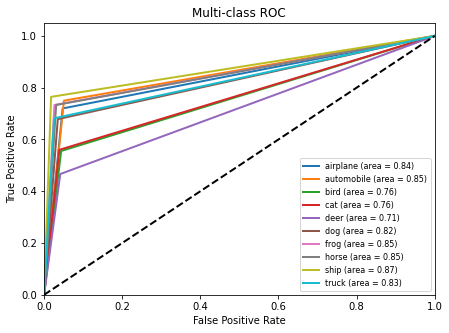

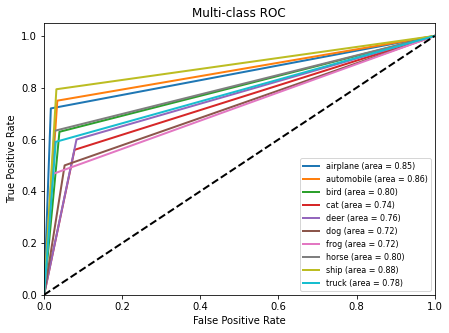

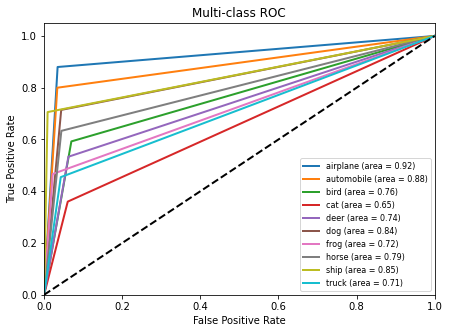

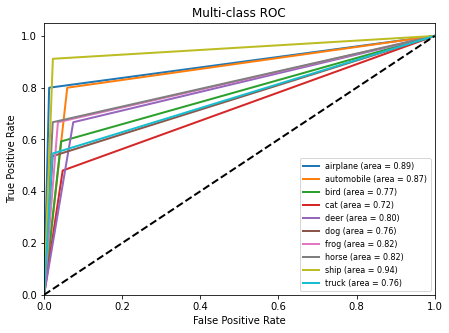

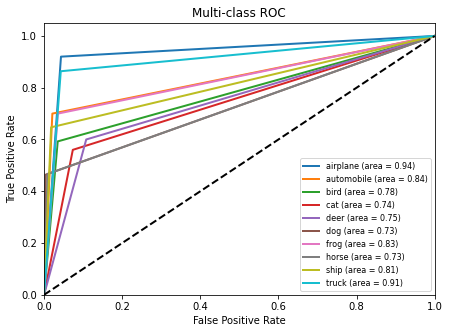

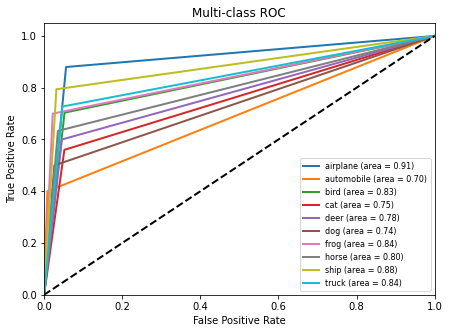

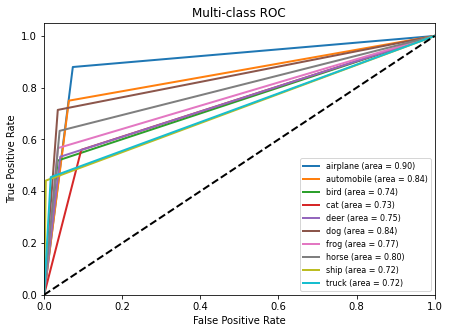

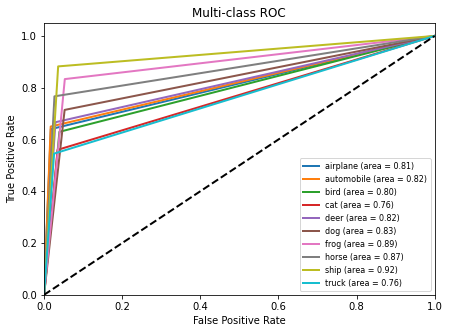

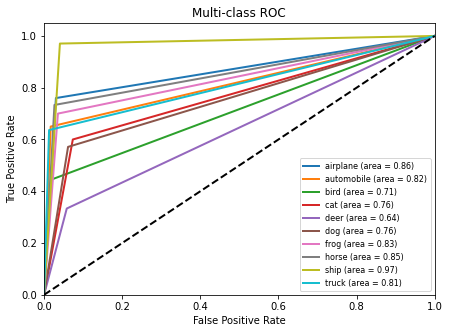

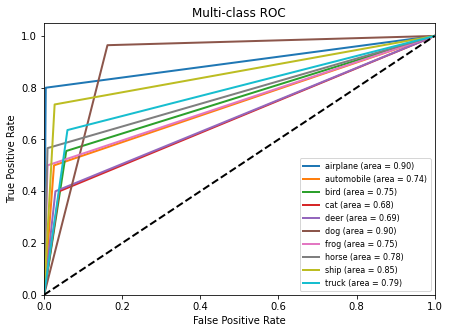

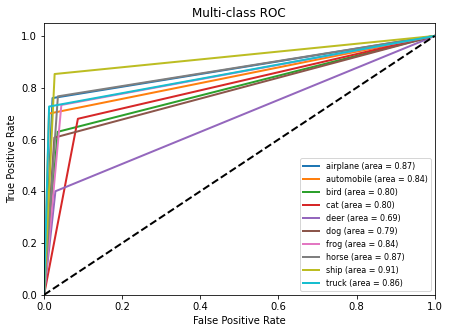

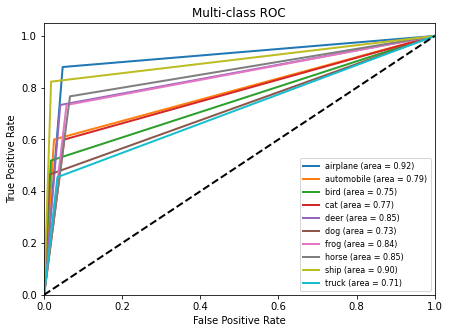

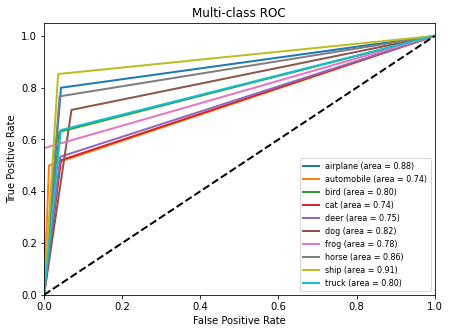

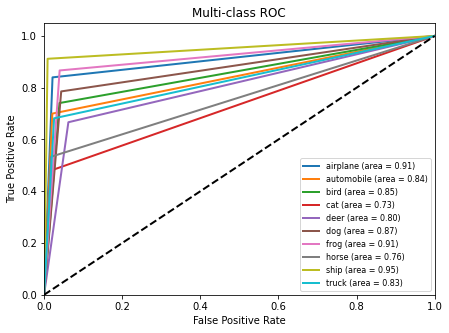

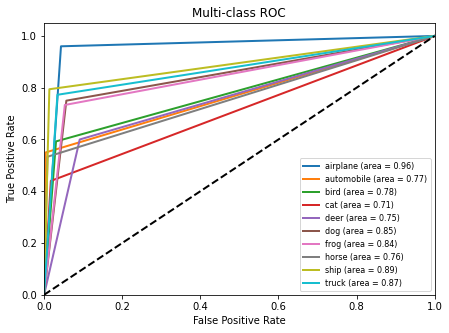

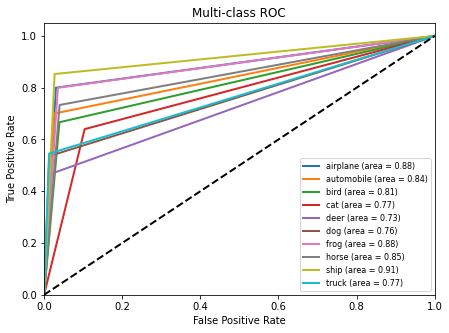

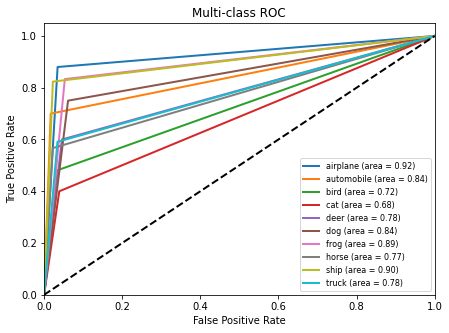

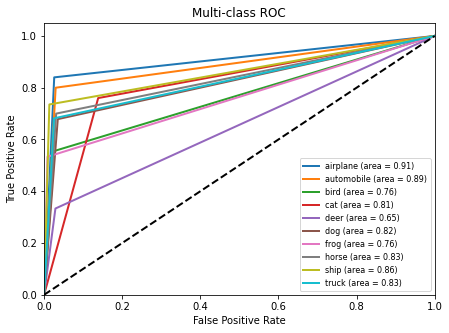

In [46]:
results_joint = { }
results_indiv = {}
num=6
for i in range(num):
    
    main = main_ce_ens(num_i=i)
    
    #train jointly: i.e. train 2 encoders (jointly) and fine tune them
    main.pretrain_joint()
    metrics_joint = main.fine_tune_joint_ensemble()

    #train individual net
    main.pretrain_indiv()
    metrics_indiv = main.fine_tune_indiv()

    results_joint[i] = metrics_joint
    results_indiv[i] = metrics_indiv

save_dict_to_gdrive(results_joint,directory,'results_joint')
save_dict_to_gdrive(results_indiv,directory,'results_indiv')

In [70]:
net_1 = []
net_2 = []
joint = []
for i in range(num):

    net_1.append(results_joint[i][0]['acc'])
    net_2.append(results_joint[i][1]['acc'])
    joint.append(results_joint[i]['ensemble_acc'])


    print(f"net 1 has acc: {results_joint[i][0]['acc']}")
    print(f"net 2 has acc: {results_joint[i][1]['acc']}")
    print(f"Ensemble acc is: {results_joint[i]['ensemble_acc']}")

    print('\n')

print(f'Individual results for net_1 are: {net_1} \n with mean {mean(net_1)}')
print(f'Individual results for net_2 are: {net_2} \n with mean {mean(net_2)}')

print(f'Ensemble results are: {joint} \n  with mean {mean(joint)}')


net 1 has acc: 0.67578125
net 2 has acc: 0.625
Ensemble acc is: 0.7109375


net 1 has acc: 0.671875
net 2 has acc: 0.64453125
Ensemble acc is: 0.6953125


net 1 has acc: 0.6015625
net 2 has acc: 0.703125
Ensemble acc is: 0.703125


net 1 has acc: 0.62109375
net 2 has acc: 0.703125
Ensemble acc is: 0.703125


net 1 has acc: 0.66796875
net 2 has acc: 0.73046875
Ensemble acc is: 0.7421875


net 1 has acc: 0.69140625
net 2 has acc: 0.671875
Ensemble acc is: 0.7109375


Individual results for net_1 are: [0.67578125, 0.671875, 0.6015625, 0.62109375, 0.66796875, 0.69140625] 
 with mean 0.6549479166666666
Individual results for net_2 are: [0.625, 0.64453125, 0.703125, 0.703125, 0.73046875, 0.671875] 
 with mean 0.6796875
Ensemble results are: [0.7109375, 0.6953125, 0.703125, 0.703125, 0.7421875, 0.7109375] 
  with mean 0.7109375


In [69]:
from itertools import combinations
from statistics import mean,stdev
def within_ensemble_results(results,key=''):

    #_results = list(results[key].values())

    _results = list(results.values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    lst=[]
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")

        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        #acc = predict_ensemble(v[0]['probs'],v[1]['probs'],dls_valid)

        print(f'Acc of ensemble is:{acc}\n')
        lst.append(acc)

    print(f"mean is: {mean(lst)}")
    print(f"std is: {stdev(lst)}\n")

lst=[results_indiv[i]['acc'] for i in range(num)]
print(f'Individual results are: {lst}')
print(f"Mean individual results: {mean(lst)}")
within_ensemble_results(results_indiv)

Individual results are: [0.6171875, 0.66015625, 0.6640625, 0.6640625, 0.6796875, 0.671875]
Mean individual results: 0.6595052083333334

Acc of first guy in ensemble is: 0.6171875
Acc of second guy in ensemble is: 0.66015625
Acc of ensemble is:0.6875


Acc of first guy in ensemble is: 0.6171875
Acc of second guy in ensemble is: 0.6640625
Acc of ensemble is:0.69140625


Acc of first guy in ensemble is: 0.6171875
Acc of second guy in ensemble is: 0.6640625
Acc of ensemble is:0.66796875


Acc of first guy in ensemble is: 0.6171875
Acc of second guy in ensemble is: 0.6796875
Acc of ensemble is:0.69921875


Acc of first guy in ensemble is: 0.6171875
Acc of second guy in ensemble is: 0.671875
Acc of ensemble is:0.6875


Acc of first guy in ensemble is: 0.66015625
Acc of second guy in ensemble is: 0.6640625
Acc of ensemble is:0.71875


Acc of first guy in ensemble is: 0.66015625
Acc of second guy in ensemble is: 0.6640625
Acc of ensemble is:0.67578125


Acc of first guy in ensemble is: 0.66015

#Ok, let's bite the bullet: train a baseline model within this session. Have to face reality:

In [66]:
with torch.no_grad():
    _,encoder = create_model('no_pretrain',device)

    model = LM(encoder,numout=10)
    learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)

learn.fit(50)


scores,preds, acc = predict_model(xval,yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=10)
#metrics dict will have f1 score, auc etc etc
metrics = classification_report_wrapper(preds, yval, dls_tune.vocab, print_report=True)


epoch,train_loss,valid_loss,time
0,2.500244,None,00:05
1,2.211926,None,00:05
2,2.062618,None,00:05
3,1.960644,None,00:05
4,1.875479,None,00:05
5,1.807530,None,00:05
6,1.755883,None,00:05
7,1.701482,None,00:05
8,1.636751,None,00:05
9,1.591244,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


              precision    recall  f1-score   support

    airplane       0.70      0.76      0.73        25
  automobile       0.60      0.45      0.51        20
        bird       0.61      0.52      0.56        27
         cat       0.48      0.44      0.46        25
        deer       0.32      0.47      0.38        15
         dog       0.50      0.43      0.46        28
        frog       0.57      0.67      0.62        30
       horse       0.59      0.63      0.61        30
        ship       0.76      0.74      0.75        34
       truck       0.59      0.59      0.59        22

    accuracy                           0.58       256
   macro avg       0.57      0.57      0.57       256
weighted avg       0.59      0.58      0.58       256



In [68]:
fnames

(#50000) [Path('/root/.fastai/data/cifar10/train/bird/38030_bird.png'),Path('/root/.fastai/data/cifar10/train/dog/9190_dog.png'),Path('/root/.fastai/data/cifar10/train/airplane/32479_airplane.png'),Path('/root/.fastai/data/cifar10/train/frog/30222_frog.png'),Path('/root/.fastai/data/cifar10/train/deer/11550_deer.png'),Path('/root/.fastai/data/cifar10/train/dog/12239_dog.png'),Path('/root/.fastai/data/cifar10/train/horse/28240_horse.png'),Path('/root/.fastai/data/cifar10/train/horse/39485_horse.png'),Path('/root/.fastai/data/cifar10/train/dog/30500_dog.png'),Path('/root/.fastai/data/cifar10/train/airplane/40317_airplane.png')...]

#Recall that:
in `cifar_random_baselines` the 50 epochs performance was [0.56640625, 0.51953125, 0.56640625, 0.5546875, 0.5390625, 0.5703125], and 100 epochs was [0.5859375, 0.56640625, 0.63671875, 0.59375, 0.61328125, 0.58984375].

So seems reasonable.